# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Import stuff.
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ast import literal_eval


# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [3]:
# Show the list of column names and the number of rules.

for column in df_rules.columns:
    print(column)
        
print(f"Number of rules: {len(df_rules)} " )

consequent_item
transaction_count
item_set_count
antecedent_count
consequent_count
antecedent_items
Number of rules: 1048575 


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [4]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = ( df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

In [5]:
# Query the rule set if you have to to find out more.

print("The yogurts have an insanely high list because there are many customers who have bought at least 1 starting yogurt(consequent) and then followed up buying another or more yogurts(antecedent list)")

The yogurts have an insanely high list because there are many customers who have bought at least 1 starting yogurt(consequent) and then followed up buying another or more yogurts(antecedent list)


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [6]:
# Define df_rules_subset.
# C = condition

# 1

# storing only rows where antecedent_items has 1 value in the list
C1 = df_rules[df_rules['antecedent_items'].apply(lambda x: len(x) == 1)]

# 2
# filtering the df to now only be consisting of life values from 5 to 20
C1 =  C1[( C1['lift'] >= 5 ) & (C1['lift'] <=20)]

# 3 

# converting antecendent_items column from list to string type 
C1['antecedent_items'] = C1['antecedent_items'].apply(lambda x: x[0])

# storing boolean values to compare rows with hummus in either column
ante_hummus = C1['antecedent_items'].apply(lambda x: 'Hummus' in str(x))
cons_hummus = C1['consequent_item'].apply(lambda x: 'Hummus' in str(x))

C1 = C1[(  ante_hummus & ~ cons_hummus   ) | ( ~ante_hummus  &  cons_hummus  )]

C1

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
377756,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,Roasted Red Pepper Hummus With Chips,0.000030,0.112740,17.623731
387837,Clementines,3346083,174,1334,32194,Organic Classic Hummus,0.000052,0.130435,13.556738
416420,Original Hummus,3346083,345,1656,74172,Organic White Pita Bread,0.000103,0.208333,9.398434
419119,Original Hummus,3346083,293,1434,74172,Organic Whole Wheat Pita,0.000088,0.204324,9.217543
422178,Original Hummus,3346083,331,1655,74172,Mini Whole Wheat Pita Bread,0.000099,0.200000,9.022496
440198,Original Hummus,3346083,3119,17333,74172,Sea Salt Pita Chips,0.000932,0.179946,8.117800
442099,Organic Baby Carrots,3346083,258,1334,80493,Organic Classic Hummus,0.000077,0.193403,8.039749
463035,Original Hummus,3346083,151,933,74172,"Lentil Chips, Himalayan Pink Salt",0.000045,0.161844,7.301163
463988,Original Hummus,3346083,311,1929,74172,Garbanzo Beans No Salt Added,0.000093,0.161223,7.273189
476420,Original Hummus,3346083,512,3333,74172,Organic Whole Peeled Baby Carrots,0.000153,0.153615,6.929970


Build a network `graph_rules_subset` from the association rules subset.

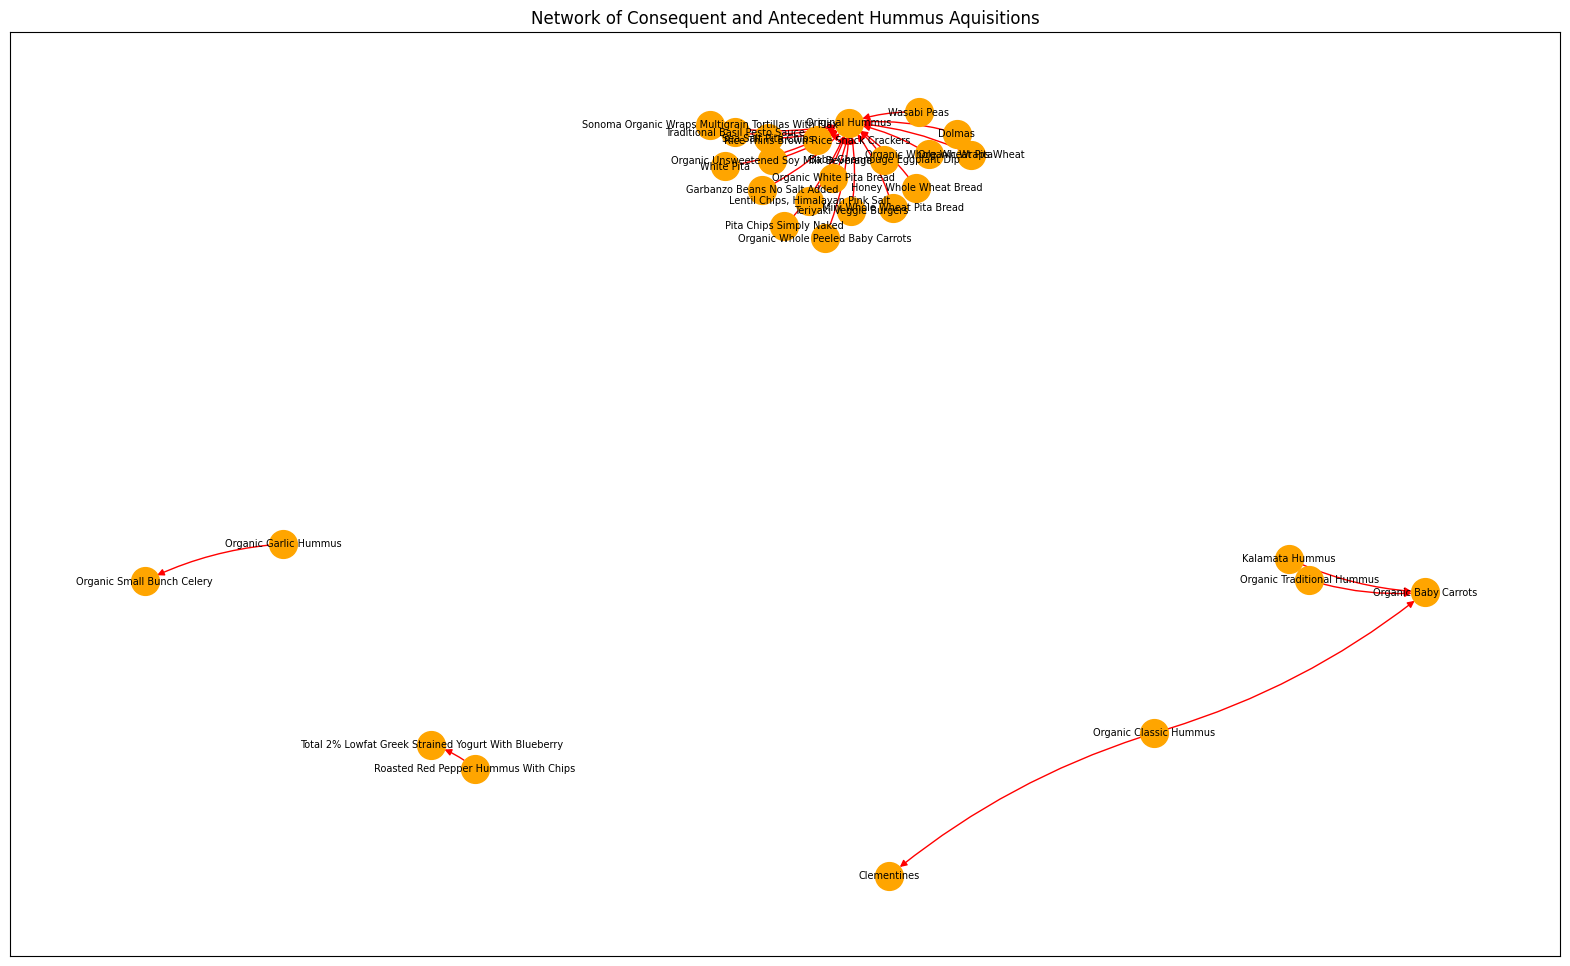

In [7]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()

edges = []

for index, row in C1.iterrows():
    edges.append((row['antecedent_items'], row['consequent_item']))
    
    
graph_rules_subset.add_edges_from(edges)


plt.figure(figsize=(20,12))
nx.draw_networkx(graph_rules_subset, 
                 node_size=400, 
                 node_color='orange',
                 font_size=7, 
                 edge_color='red',
                 connectionstyle='arc3, rad=0.1')
plt.title("Network of Consequent and Antecedent Hummus Aquisitions")
plt.show()
# Then render the graph.

What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [8]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

#filts for antecedent item that contains anything from basket

df_rules[df_rules['antecedent_items'].apply(basket.issuperset)  # issuperset checks to see if the element(x which is our item list) contains elements from the basket
                                                                                  # This stores only rows that include both items in the basket
                                                                                  # can also use intersection
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
364989,Organic Bell Pepper,3346083,582,2721,24331,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000174,0.213892,29.415159
370144,Yellow Bell Pepper,3346083,499,2721,26625,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000149,0.183388,23.047249
370169,Yellow Bell Pepper,3346083,7520,41052,26625,[Orange Bell Pepper],0.002247,0.183182,23.021341
386994,Organic Bell Pepper,3346083,6024,59878,24331,[Organic Red Bell Pepper],0.001800,0.100605,13.835486
404185,Green Bell Pepper,3346083,494,2721,58005,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000148,0.181551,10.472966
449846,Red Peppers,3346083,5529,41052,58185,[Orange Bell Pepper],0.001652,0.134683,7.745295
480595,Green Bell Pepper,3346083,7086,59878,58005,[Organic Red Bell Pepper],0.002118,0.118341,6.826611
531201,Green Bell Pepper,3346083,4144,41052,58005,[Orange Bell Pepper],0.001238,0.100945,5.823133
603392,Organic Red Onion,3346083,278,2721,70804,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000083,0.102168,4.828310
657541,Organic Cucumber,3346083,6480,59878,85005,[Organic Red Bell Pepper],0.001937,0.108220,4.259905


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.